In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from calendar import month_name
import re
from tqdm import tqdm, trange

tqdm.pandas()
def delta0():
    return pd.Timedelta(0)

# Data Loading and Processing

## Taarif

In [2]:
taarif = pd.read_csv('taarif.csv', skiprows=[1], index_col='customer')
translate_dict = {'mizranei_kfar_saba': 'aminach', 'dbs': 'yes', 'telecommunication_ltd': 'hot'}

# translate names
taarif.index = taarif.index.map(lambda s: translate_dict.get(s, s))
taarif.loc[:, 'night_bonus':'weekend_bonus'] /= 100

# fill in missing values
taarif.loc['electricity'] = [5, 5, 0, 0]
taarif.loc['bituch_leumi'] = [5, 5, 0, 0]

# fix values which are too big
taarif.loc['iaf', 'night_bonus':] /= 10
taarif.loc['angel', 'night_bonus'] /= 10
taarif.loc['jerusalem_muni', 'extra_milage'] /= 10

taarif

,basic_taarif,extra_milage,night_bonus,weekend_bonus
customer,,,,
jerusalem_muni,8.0,4.0,0.5,0.30
intel,8.0,6.0,0.2,0.00
aminach,15.0,4.0,0.0,0.25
yes,10.0,8.0,0.0,0.25
tnuva,6.0,3.0,0.8,0.00
angel,1.0,5.0,0.1,0.00
hot,7.0,7.0,0.1,0.40
osem,12.0,4.0,0.2,0.00
iaf,20.0,10.0,0.2,0.50


## Drivers

In [3]:
new_drivers = pd.read_csv('new_drivers.csv', index_col=0)
new_drivers['vetek'] /= 365
senior_drivers = pd.read_csv('Drivers_with_kviut.csv', index_col=0)

drivers = pd.concat([new_drivers, senior_drivers]).rename(columns={'id': 'driver_id'})
drivers.birthdate = pd.to_datetime(drivers.birthdate)
translate_dict = {**dict.fromkeys(['M', 'm', 'boy'], 'male'),
                  **dict.fromkeys(['woman', 'F', 'girl'], 'female'),
                 **dict.fromkeys(['unknown', 'none'], np.nan)}
drivers.gender = drivers.gender.apply(lambda s: translate_dict.get(s, s))
drivers.vetek = drivers.vetek.round(1)

### Handling missing values

In case of missing or placeholder birthdate, I've set the age of the driver to be the median age.

In case of missing gender, I've set the value to unknown

In [4]:
drivers.loc[drivers.birthdate == '1900-01-01', 'birthdate'] = np.nan  # removing placeholder value
drivers['age'] = ((pd.Timestamp('now') - drivers.birthdate) / pd.Timedelta(days=365.25)).round(1)
drivers.gender = drivers.gender.fillna('unknown')

## Trips Data

In [5]:
trip_dfs = {}
for i in trange(1, 13):
    month = month_name[i].lower()
    trip_dfs[month] = {}
    for file in Path('trips_data').glob(f'{month}*'):
        df = pd.read_csv(file, index_col=0, parse_dates=['end_time', 'start_time'])
        df['month'] = f'{i}/2015'
        
        truck_id = re.findall('\d+', file.name)[1]
        if truck_id not in trip_dfs[month]:
            trip_dfs[month][truck_id] = df

month_dfs = [pd.concat(trip_dfs[m].values()) for m in trip_dfs]
trips = pd.concat(month_dfs, ignore_index=True)

trips['duration'] = trips.end_time - trips.start_time
trips['speed'] = trips.km / (trips.duration.dt.total_seconds() / 60 ** 2)

# fixing trips with weird speeds and distances
trips.loc[trips.speed < 40, 'speed'] = np.nan
trips.loc[trips.speed < 40, 'end_time'] = pd.NaT

trips.loc[trips.speed > 100, 'speed'] = np.nan
trips.loc[trips.speed > 100, 'km'] = np.nan
trips.loc[trips.speed > 100, 'end_time'] = pd.NaT

trips.loc[trips.km > 1000, 'speed'] = np.nan
trips.loc[trips.km > 1000, 'km'] = np.nan
trips.loc[trips.km > 1000, 'end_time'] = pd.NaT

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.58s/it]


Filling in missing start and end values drives

In [6]:
no_times_index = (trips.start_time.isna() & trips.end_time.isna())
trips.loc[no_times_index, 'start_time'] = \
    pd.to_datetime(trips[no_times_index].month, format='%m/%Y') + pd.Timedelta(hours=6)

for driver_id, df in tqdm(trips.groupby('driver_id')):
    if df.km.isna().any():
        trips.loc[trips.driver_id == driver_id, 'km'] = \
            trips.loc[trips.driver_id == driver_id, 'km'].fillna(df.km.mean())

for driver_id, df in tqdm(trips.groupby('driver_id')):
    if df.duration.isna().any():
        trips.loc[trips.driver_id == driver_id, 'duration'] = \
            trips.loc[trips.driver_id == driver_id, 'duration'].fillna(
                pd.to_timedelta(df[df.duration.isna()].km / df.speed.mean(), unit='h').round('60s'))
        
no_end = trips[trips.end_time.isna()]
filled_end_times = no_end.start_time + no_end.duration
trips.end_time = trips.end_time.fillna(filled_end_times)

no_start = trips[trips.start_time.isna()]
filled_start_times = no_start.end_time - no_start.duration
trips.start_time = trips.start_time.fillna(filled_start_times)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 50.65it/s]



Finding how much of each drive is during the night and during the weekend

In [7]:
class TimeRange:
    def __init__(self, start, end):
        assert start < end, 'Start must be smaller than end!'
        self.start = start
        self.end = end
    
    @property
    def length(self):
        return self.end - self.start
    
def get_overlap(range1, range2):
    end = range1[1].clip(upper=range2[1]) 
    start = range1[0].clip(lower=range2[0]) 
    overlap = end - start 
    return overlap.clip(lower=delta0())

def get_next_day(day, n=1):
    return day + pd.Timedelta(days=n)
    
    
def get_nights_in_range(time_range):
    def get_last_night(day):
        night_start = get_next_day(day, -1).replace(hour=22)
        night_end = day.replace(hour=6)
        return (night_start, night_end)

    nights = []
    for day in [get_next_day(time_range.start, i) for i in range(time_range.length.days + 2)]:
        nights.append(get_last_night(day))
    return nights


def get_weekends_in_range(time_range):
    def get_this_weekend(day):
        friday = day + pd.Timedelta(days=4 - day.weekday())
        saturday = friday + pd.Timedelta(days=1)
        weekend = (friday.replace(hour=16), saturday.replace(hour=20))
        return weekend
    
    weekends = []
    if time_range.start.isoweekday() == 6:
        weekends.append(get_this_weekend(time_range.start))
        
    for day in [get_next_day(time_range.start, i) for i in range(time_range.length.days + 2)]:
        if day.isoweekday() == 5:
            weekends.append(get_this_weekend(day))
    return weekends


trips['km_night'] = 0
trips['km_weekend'] = 0
trips['km_night_extra'] = 0
trips['km_weekend_extra'] = 0

trips['base_km'] = trips.km.clip(upper=200)
trips['extra_km'] = (trips.km - 200).clip(lower=0)

no_extra_index = trips.km <= 200
trips['time_200'] = trips.start_time + trips.duration * 200 / trips.km
trips.loc[no_extra_index, 'time_200'] = trips.end_time[no_extra_index]

def compute_km_in_ranges(start_time, end_time, total_km, time_ranges):
    total = delta0()
    for time_range in time_ranges:
        total += get_overlap((start_time, end_time), time_range)
    return total / (end_time - start_time) * total_km
    
for m, df in trips.groupby(trips.start_time.dt.month):
    m_index = trips.start_time.dt.month == m
    nights = get_nights_in_range(TimeRange(df.start_time.min(), df.end_time.max()))
    weekends = get_weekends_in_range(TimeRange(df.start_time.min(), df.end_time.max()))
    
    trips.loc[m_index, 'km_night'] = compute_km_in_ranges(df.start_time, df.time_200, df.base_km, nights)
    trips.loc[m_index, 'km_weekend'] = compute_km_in_ranges(df.start_time, df.time_200, df.base_km, weekends)
    trips.loc[m_index, 'km_night_extra'] = compute_km_in_ranges(df.time_200, df.end_time, df.extra_km, nights)
    trips.loc[m_index, 'km_weekend_extra'] = compute_km_in_ranges(df.time_200, df.end_time, df.extra_km, weekends)

trips[['km_night_extra', 'km_weekend_extra']] = trips[['km_night_extra', 'km_weekend_extra']].fillna(0)

# Generate Summary

In [8]:
trips['pay'] = 0
for customer, df in trips.groupby('customer'):
    rates = taarif.loc[customer]
    pay = rates.basic_taarif * (df.base_km + rates.night_bonus * df.km_night + 
                                rates.weekend_bonus * df.km_weekend) + \
        rates.extra_milage * (df.extra_km + rates.night_bonus * df.km_night_extra + 
                              rates.weekend_bonus * df.km_weekend_extra)
    trips.loc[trips.customer == customer, 'pay'] = pay
trips.pay = trips.pay.clip(upper=trips.pay.quantile(0.99))

In [9]:
summary = trips.groupby(['month', 'driver_id']).agg({'pay': 'sum', 'km': 'sum'}).reset_index()\
    .round({'pay': 1, 'km': 1}).rename(columns={'km': 'total_km', 'pay': 'total_income'})
summary = drivers.merge(summary, on='driver_id').drop(columns=['birthdate'])
summary.to_csv('summary.csv')
summary

,gender,driver_id,vetek,age,month,total_income,total_km
0,female,943,0.6,55.8,1/2015,70216.0,8900.1
1,female,943,0.6,55.8,10/2015,77861.2,9091.6
2,female,943,0.6,55.8,11/2015,71337.0,9415.8
3,female,943,0.6,55.8,12/2015,78821.2,9961.8
4,female,943,0.6,55.8,2/2015,58235.7,8061.2
...,...,...,...,...,...,...,...
11995,male,609,4.6,NaN,5/2015,69500.3,8479.2
11996,male,609,4.6,NaN,6/2015,53489.1,7346.8
11997,male,609,4.6,NaN,7/2015,79004.5,9178.0
11998,male,609,4.6,NaN,8/2015,69640.9,7894.9


In [10]:
summary[['total_income', 'total_km']].mean().round(2)

total_income    67493.57
total_km         8395.87
dtype: float64

Each driver has a line in the summary table.

In [11]:
summary.groupby('driver_id').size().value_counts()

12    1000
dtype: int64

There are no missing values

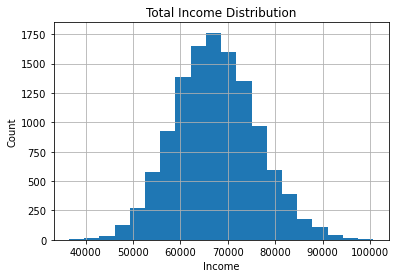

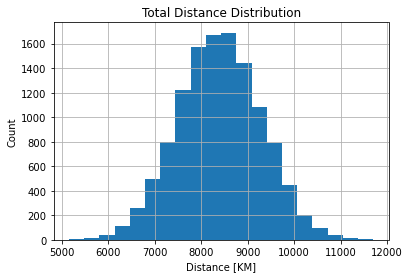

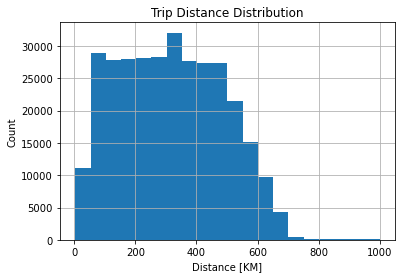

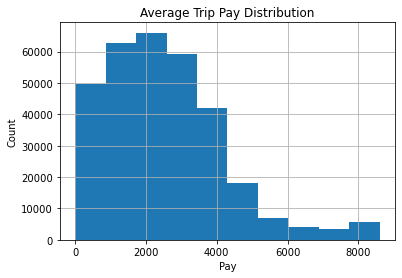

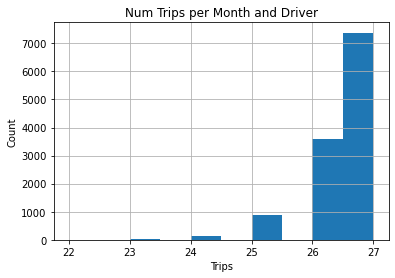

In [32]:
summary.hist('total_income', bins=20)
plt.title('Total Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

summary.hist('total_km', bins=20)
plt.title('Total Distance Distribution')
plt.xlabel('Distance [KM]')
plt.ylabel('Count')
plt.show()

trips.km.hist(bins=20)
plt.title('Trip Distance Distribution')
plt.xlabel('Distance [KM]')
plt.ylabel('Count')
plt.show()

trips.pay.hist()
plt.title('Average Trip Pay Distribution')
plt.xlabel('Pay')
plt.ylabel('Count')
plt.show()

trips.groupby(['month', 'driver_id']).size().hist()
plt.title('Num Trips per Month and Driver')
plt.xlabel('Trips')
plt.ylabel('Count')
plt.show()